In [2]:
#csvファイルを読み込む
import pandas as pd

# ファイルパス（適宜変更してください）
file_path = "global-energy-substitution.csv"

# 読み込み
df = pd.read_csv(file_path)

# 先頭5行を確認
print(df.head())

# データの概要
print(df.info())



  Entity      Code  Year  Other renewables (TWh, substituted energy)  \
0  World  OWID_WRL  1800                                         0.0   
1  World  OWID_WRL  1810                                         0.0   
2  World  OWID_WRL  1820                                         0.0   
3  World  OWID_WRL  1830                                         0.0   
4  World  OWID_WRL  1840                                         0.0   

   Biofuels (TWh, substituted energy)  Solar (TWh, substituted energy)  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   

   Wind (TWh, substituted energy)  Hydropower (TWh, substituted energy)  \
0                             0.0              

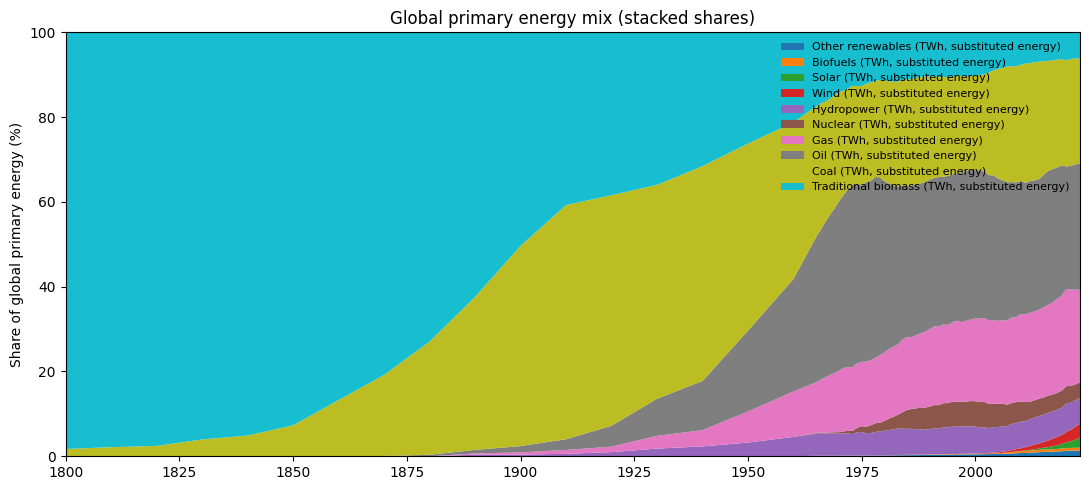

In [ ]:
# === Global energy mix stacked area (shares %) ===
# 必要: pandas, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ▼あなたのCSVファイルのパスに変更
csv_path = "global-energy-substitution.csv"

# ---- 1) データ読み込み ----
df = pd.read_csv(csv_path)

# Entity列がある場合、Worldのみに絞る
if "Entity" in df.columns and df["Entity"].dtype == object:
    df = df[df["Entity"].str.lower() == "world"].copy()

# エネルギー列を抽出
energy_cols = [c for c in df.columns if "(TWh" in c or c.endswith("(TWh)")]
if "Year" not in df.columns or not energy_cols:
    raise ValueError("CSVに 'Year' 列と '...(TWh)' 列が必要です。")

# 表示順の調整（存在する列のみ）
preferred_order = [
    "Other renewables (TWh)",
    "Biofuels (TWh)",
    "Solar (TWh)",
    "Wind (TWh)",
    "Hydropower (TWh)",
    "Nuclear (TWh)",
    "Natural gas (TWh)",
    "Oil (TWh)",
    "Coal (TWh)"
]
ordered_cols = [c for c in preferred_order if c in energy_cols] + \
               [c for c in energy_cols if c not in preferred_order]

dfp = df[["Year"] + ordered_cols].sort_values("Year").copy()
for c in ordered_cols:
    dfp[c] = pd.to_numeric(dfp[c], errors="coerce")

# ---- 2) 構成比（%）を計算 ----
total = dfp[ordered_cols].sum(axis=1, skipna=True)
total = total.replace(0, np.nan)
shares = (dfp[ordered_cols].div(total, axis=0) * 100.0).astype(float).fillna(0.0)

# ---- 3) プロット ----
plt.figure(figsize=(11, 5))
plt.stackplot(dfp["Year"].values, shares[ordered_cols].values.T, labels=ordered_cols)
plt.xlim(dfp["Year"].min(), dfp["Year"].max())
plt.ylim(0, 100)
plt.ylabel("Share of global primary energy (%)")
plt.title("Global primary energy mix (stacked shares)")
plt.legend(loc="upper right", ncol=1, fontsize=8, frameon=False)
plt.tight_layout()
plt.show()



Saved normalized modern energy ratio → World_modern_energy_rate.npy
Shape: (76, 2), years 1800–2023

Fitted logistic: a=0.9994, b=42.1694, c=0.03583
→ k=0.03583, x*=1904.43


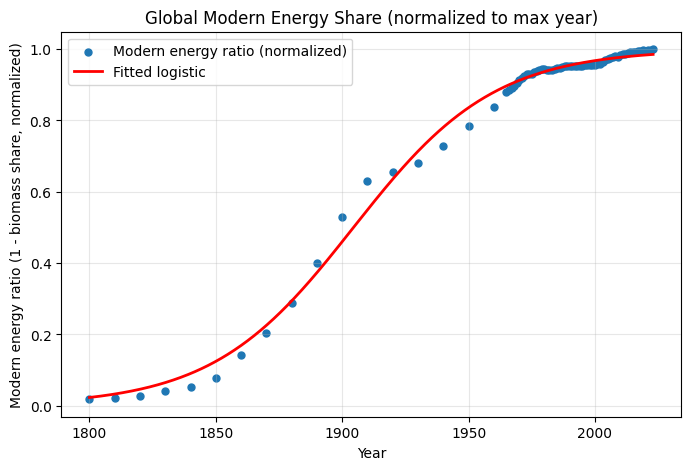

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# ========= 0) データ読み込み =========
file_path = "global-energy-substitution.csv"
df = pd.read_csv(file_path)

# World データだけ使用
df_w = df[df["Entity"] == "World"].copy()

# ========= 1) Modern energy ratio の算出 =========
energy_cols = [c for c in df_w.columns if "TWh, substituted energy" in c]
df_w["Total_energy_TWh"] = df_w[energy_cols].sum(axis=1)

biomass_col = "Traditional biomass (TWh, substituted energy)"
df_w["Trad_share"] = df_w[biomass_col] / df_w["Total_energy_TWh"]
df_w["Modern_ratio_raw"] = 1.0 - df_w["Trad_share"]

# 欠損を除外
mask = ~np.isnan(df_w["Modern_ratio_raw"])
years = df_w.loc[mask, "Year"].astype(float).values
vals  = df_w.loc[mask, "Modern_ratio_raw"].astype(float).values

# ========= 2) 上昇期のみ抽出＋正規化 =========
imax = np.nanargmax(vals)
year_max = years[imax]
val_max = vals[imax]
mask_growth = years <= year_max
years_growth = years[mask_growth]
vals_growth  = vals[mask_growth]
vals_norm = np.clip(vals_growth / val_max, 1e-4, 1-1e-4)

# ========= ✅ Modern energy ratio を npy で保存 =========
arr = np.column_stack((years_growth, vals_norm))
out_path = "World_modern_energy_rate.npy"
np.save(out_path, arr)
print(f"\nSaved normalized modern energy ratio → {out_path}")
print(f"Shape: {arr.shape}, years {years_growth.min():.0f}–{years_growth.max():.0f}")

# ========= 3) ロジスティック関数でフィット =========
def model_func(x, a, b, c):
    x = np.asarray(x, dtype=float)
    x0 = x.min()
    return a / (1.0 + b * np.exp(-c * (x - x0)))

p0 = [1.0, 1.0, 0.03]
bounds = ([0.5, 0.0, 1e-4], [1.2, 1e6, 1.0])
popt, pcov = curve_fit(model_func, years_growth, vals_norm, p0=p0,
                       bounds=bounds, maxfev=200000)
a, b, c = popt

x0 = years_growth.min()
lnb = np.log(b)
k = c
x_star = x0 + lnb / c
print(f"\nFitted logistic: a={a:.4f}, b={b:.4f}, c={c:.5f}")
print(f"→ k={k:.5f}, x*={x_star:.2f}")

# ========= 4) 可視化 =========
t_grid = np.linspace(years_growth.min(), year_max, 600)
yhat = model_func(t_grid, *popt)
plt.figure(figsize=(8,5))
plt.scatter(years_growth, vals_norm, s=25, label="Modern energy ratio (normalized)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (1 - biomass share, normalized)")
plt.title("Global Modern Energy Share (normalized to max year)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Reduce data frequency after 1970

Normalization reference year (max modern ratio): 2023
Value at that year: 0.939
Data used for fitting: 1800–2023
Number of original points: 76
Number of 10-year bins: 23
Saved 10-year binned modern energy rate → World_modern_energy_rate.npy
Shape: (23, 2), years 1800–2020

=== Fitted parameters (10-year binned, normalized) ===
a = 0.986378  (SE=0.0191, 95% CI [0.94649, 1.02627])
b = 49.2744  (SE=10.8, 95% CI [26.804, 71.7449])
c = 0.0379284  (SE=0.00238, 95% CI [0.0329624, 0.0428944])

Standard logistic form:
  k  = 0.037928
  x* = 1902.76  # 50% modern-energy year (inflection)


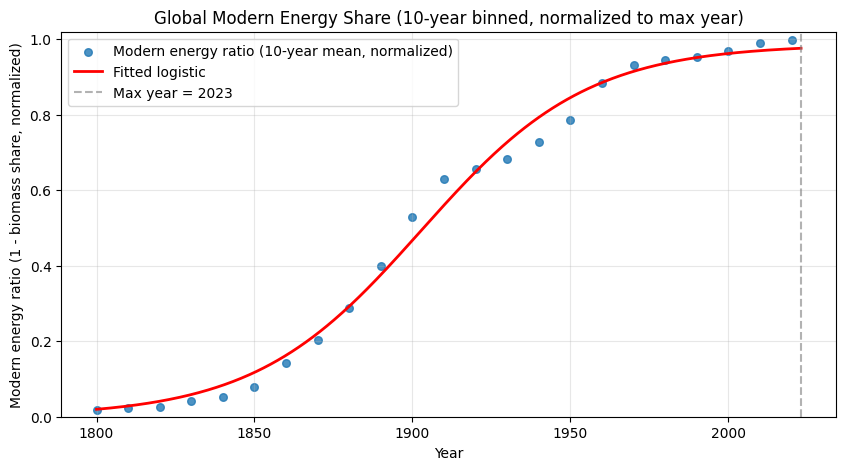

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

# ========= 0) データ読み込み =========
file_path = "global-energy-substitution.csv"
df = pd.read_csv(file_path)

# World データだけ使用
df_w = df[df["Entity"] == "World"].copy()

# ========= 1) Modern energy ratio の算出 =========
# TWh 列を全て拾う
energy_cols = [c for c in df_w.columns if "TWh, substituted energy" in c]

# 総エネルギー
df_w["Total_energy_TWh"] = df_w[energy_cols].sum(axis=1)

# 伝統的バイオマスのシェア
biomass_col = "Traditional biomass (TWh, substituted energy)"
df_w["Trad_share"] = df_w[biomass_col] / df_w["Total_energy_TWh"]

# Modern energy ratio = 1 - biomass share
df_w["Modern_ratio_raw"] = 1.0 - df_w["Trad_share"]

# 欠損を除外
mask = ~np.isnan(df_w["Modern_ratio_raw"])
years_all = df_w.loc[mask, "Year"].astype(float).values
vals_all  = df_w.loc[mask, "Modern_ratio_raw"].astype(float).values

# ========= 2) 上昇期のみ抽出＋正規化 =========
EPS_LOW, EPS_HIGH = 1e-4, 1-1e-4

# 最大値となる年
imax = np.nanargmax(vals_all)
year_max = years_all[imax]
val_max  = vals_all[imax]

# その年までのデータを使用
mask_growth = years_all <= year_max
years_growth = years_all[mask_growth]
vals_growth  = vals_all[mask_growth]

# 正規化 → year_max で Modern ratio = 1 になる
vals_norm = vals_growth / val_max
vals_norm = np.clip(vals_norm, EPS_LOW, EPS_HIGH)

print(f"Normalization reference year (max modern ratio): {year_max:.0f}")
print(f"Value at that year: {val_max:.3f}")
print(f"Data used for fitting: {years_growth.min():.0f}–{years_growth.max():.0f}")

# ========= 3) 10年ビン平均（データが多い部分の重みをならす） =========
bins = (years_growth // 10).astype(int) * 10   # 10年ごとに丸める
uniq_bins = np.unique(bins)
x10 = uniq_bins.astype(float)
y10 = np.array([np.mean(vals_norm[bins == b]) for b in uniq_bins], dtype=float)

print(f"Number of original points: {len(years_growth)}")
print(f"Number of 10-year bins: {len(x10)}")

# ========= 4) npy に保存（year, modern_ratio） =========
arr = np.column_stack((x10, y10))
out_path = "World_modern_energy_rate.npy"
np.save(out_path, arr)
print(f"Saved 10-year binned modern energy rate → {out_path}")
print(f"Shape: {arr.shape}, years {x10.min():.0f}–{x10.max():.0f}")

# ========= 5) ロジスティック関数でフィット =========
def model_func(x, a, b, c):
    x = np.asarray(x, dtype=float)
    x0 = x.min()  # 数値安定化
    return a / (1.0 + b * np.exp(-c * (x - x0)))

p0 = [1.0, 1.0, 0.03]
bounds = ([0.5, 0.0, 1e-4], [1.2, 1e6, 1.0])

popt, pcov = curve_fit(model_func, x10, y10, p0=p0,
                       bounds=bounds, maxfev=200000)
a, b, c = popt
perr = np.sqrt(np.diag(pcov))

# 標準ロジスティック形への変換
x0 = x10.min()
lnb = np.log(b)
k = c
x_star = x0 + lnb / c  # 50%転換年

# 95% CI
ALPHA = 0.05
dof = max(len(x10) - len(popt), 1)
tval = t.ppf(1 - ALPHA/2, dof)

print("\n=== Fitted parameters (10-year binned, normalized) ===")
for name, val, se in zip(['a','b','c'], popt, perr):
    ci_low  = val - tval * se
    ci_high = val + tval * se
    print(f"{name} = {val:.6g}  (SE={se:.3g}, 95% CI [{ci_low:.6g}, {ci_high:.6g}])")

print(f"\nStandard logistic form:")
print(f"  k  = {k:.6f}")
print(f"  x* = {x_star:.2f}  # 50% modern-energy year (inflection)")

# ========= 6) プロット =========
t_grid = np.linspace(x10.min(), year_max, 600)
yhat = model_func(t_grid, *popt)

plt.figure(figsize=(10,5))
plt.scatter(x10, y10, s=30, alpha=0.8,
            label="Modern energy ratio (10-year mean, normalized)")
plt.plot(t_grid, yhat, "r-", lw=2, label="Fitted logistic")
plt.axvline(year_max, color="gray", ls="--", alpha=0.6,
            label=f"Max year = {year_max:.0f}")
plt.xlabel("Year")
plt.ylabel("Modern energy ratio (1 - biomass share, normalized)")
plt.title("Global Modern Energy Share (10-year binned, normalized to max year)")
plt.ylim(0, 1.02)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
